In [4]:
cd ../../src

/Users/in-divye.singh/Documents/Projects/MIC_predictor/src


In [5]:
import biovec
import numpy as np
import pandas as pd
from itertools import chain, combinations
from collections import Counter

from utils import *

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from Bio.SeqUtils.ProtParam import ProteinAnalysis

In [6]:
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop, Adam, SGD
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

In [7]:
import seaborn as sns

In [8]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [9]:
avp_ic50 = pd.read_csv("../data/raw/AVP-IC50Pred_train.csv")
ha_avp = pd.read_csv("../data/raw/HA_AVP.csv")

In [10]:
df = pd.concat([avp_ic50[['Sequence','MIC']], ha_avp], axis=0).drop_duplicates(['Sequence']).reset_index(drop=True)
df = sequence_filtering(df)

In [21]:
df2 = df[df['MIC'] >= 1e-3].reset_index(drop=True)

In [22]:
df2

,Sequence,MIC,pIC50
0,AAQRRGRVGRNPNQVGD,442.00000,7.724201
1,HRILARIRQMMT,435.50000,7.739016
2,RNPSQVGD,383.00000,7.867476
3,RVGRNPNQVGD,374.00000,7.891255
4,AAQRRGRIGRNPSQVGD,358.00000,7.934978
...,...,...,...
702,SLDQINVTFLDLEYEMKKLEEAIKKLEESYIDLKEL,0.00130,20.460902
703,NGAICWGPCPTAFRQIGNCGHFKVRCCKIR,0.11515,15.977030
704,CFPYITRPGTYHDWWYTRKNRQ,0.30000,15.019483
705,YTSLIHSLIEESQNQQEKNEQELLELDKWASLWNWF,0.01131,18.297579


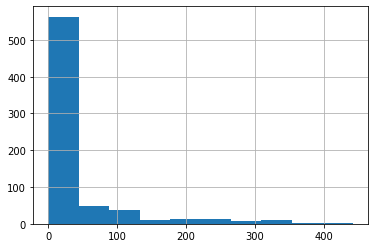

In [24]:
df2['MIC'].hist()

In [25]:
df2['pIC50'] = df2['MIC'].apply(lambda x: -np.log(x*1e-6))

In [26]:
df2

,Sequence,MIC,pIC50
0,AAQRRGRVGRNPNQVGD,442.00000,7.724201
1,HRILARIRQMMT,435.50000,7.739016
2,RNPSQVGD,383.00000,7.867476
3,RVGRNPNQVGD,374.00000,7.891255
4,AAQRRGRIGRNPSQVGD,358.00000,7.934978
...,...,...,...
702,SLDQINVTFLDLEYEMKKLEEAIKKLEESYIDLKEL,0.00130,20.460902
703,NGAICWGPCPTAFRQIGNCGHFKVRCCKIR,0.11515,15.977030
704,CFPYITRPGTYHDWWYTRKNRQ,0.30000,15.019483
705,YTSLIHSLIEESQNQQEKNEQELLELDKWASLWNWF,0.01131,18.297579


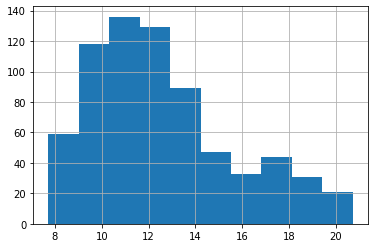

In [27]:
df2['pIC50'].hist()

In [28]:
X = df2['Sequence']
y = df2['MIC']

In [66]:
max_len = df2['Sequence'].apply(lambda s: len(s)).max()

In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.20,random_state=42)

In [59]:
def pep2seq(data: pd.Series) -> list:
    AA = ['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
    sequences = data.apply(lambda seq: [AA.index(aa)+1 for aa in seq])
    return sequences

In [70]:
sequences = pep2seq(X_train)

In [71]:
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [108]:
def get_model():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(21,150,input_length=max_len)(inputs)
    layer = LSTM(128, return_sequences=True)(layer)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('relu')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [109]:
model = get_model()
model.summary()
model.compile(loss="mse",optimizer=Adam(),metrics=["mse"])

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 61)]              0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 61, 150)           3150      
_________________________________________________________________
lstm_9 (LSTM)                (None, 61, 128)           142848    
_________________________________________________________________
lstm_10 (LSTM)               (None, 64)                49408     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_14 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0   

In [110]:
history = model.fit(sequences_matrix,Y_train,batch_size=128,epochs=100,validation_split=0.2)

Epoch 1/100
4/4 [==============================] - 1s 351ms/step - loss: 6131.3447 - mse: 6131.3447 - val_loss: 8391.9023 - val_mse: 8391.9023
Epoch 2/100
4/4 [==============================] - 0s 88ms/step - loss: 6081.8018 - mse: 6081.8018 - val_loss: 8173.7656 - val_mse: 8173.7656
Epoch 3/100
4/4 [==============================] - 0s 88ms/step - loss: 5900.4976 - mse: 5900.4976 - val_loss: 7941.5977 - val_mse: 7941.5977
Epoch 4/100
4/4 [==============================] - 0s 94ms/step - loss: 5748.6885 - mse: 5748.6885 - val_loss: 7716.7153 - val_mse: 7716.7153
Epoch 5/100
4/4 [==============================] - 0s 96ms/step - loss: 5566.8682 - mse: 5566.8682 - val_loss: 7475.1831 - val_mse: 7475.1831
Epoch 6/100
4/4 [==============================] - 0s 92ms/step - loss: 5398.4658 - mse: 5398.4658 - val_loss: 7241.9668 - val_mse: 7241.9668
Epoch 7/100
4/4 [==============================] - 0s 91ms/step - loss: 5269.5400 - mse: 5269.5400 - val_loss: 7041.7075 - val_mse: 7041.7075
Epoch

4/4 [==============================] - 0s 94ms/step - loss: 5065.7910 - mse: 5065.7910 - val_loss: 6696.4448 - val_mse: 6696.4448
Epoch 59/100
4/4 [==============================] - 0s 88ms/step - loss: 5074.7241 - mse: 5074.7241 - val_loss: 6695.5122 - val_mse: 6695.5122
Epoch 60/100
4/4 [==============================] - 0s 87ms/step - loss: 5072.7456 - mse: 5072.7456 - val_loss: 6699.8101 - val_mse: 6699.8101
Epoch 61/100
4/4 [==============================] - 0s 86ms/step - loss: 5035.3784 - mse: 5035.3784 - val_loss: 6700.5474 - val_mse: 6700.5474
Epoch 62/100
4/4 [==============================] - 0s 91ms/step - loss: 5066.0835 - mse: 5066.0835 - val_loss: 6704.0898 - val_mse: 6704.0898
Epoch 63/100
4/4 [==============================] - 0s 88ms/step - loss: 5041.1133 - mse: 5041.1133 - val_loss: 6700.1016 - val_mse: 6700.1016
Epoch 64/100
4/4 [==============================] - 0s 90ms/step - loss: 5073.3779 - mse: 5073.3779 - val_loss: 6697.0049 - val_mse: 6697.0049
Epoch 65/100

In [93]:
import matplotlib.pyplot as plt

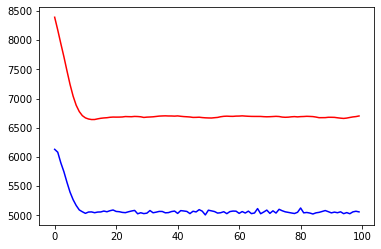

In [111]:
mse = history.history['mse']
val_mse = history.history['val_mse']
plt.plot(mse, c='blue')
plt.plot(val_mse, c='red')

In [105]:
test_seq = pep2seq(X_test)
test_seq_mat = sequence.pad_sequences(test_seq,maxlen=max_len)

In [89]:
model.predict(test_seq_mat)

array([[30.742304],
       [31.269938],
       [31.574347],
       [31.465834],
       [31.532663],
       [31.52527 ],
       [30.754152],
       [30.742292],
       [31.23253 ],
       [31.389181],
       [31.005402],
       [31.292719],
       [31.296791],
       [31.532461],
       [31.47369 ],
       [31.499907],
       [30.682972],
       [31.163565],
       [30.795961],
       [30.92061 ],
       [31.389467],
       [31.231401],
       [31.16609 ],
       [30.7633  ],
       [30.826181],
       [31.477575],
       [30.752647],
       [30.762926],
       [30.985254],
       [30.881594],
       [31.642246],
       [31.446886],
       [31.181093],
       [31.533037],
       [30.237944],
       [30.945675],
       [30.914238],
       [30.98503 ],
       [30.66792 ],
       [30.783403],
       [30.794046],
       [31.353773],
       [31.533003],
       [31.45766 ],
       [30.84175 ],
       [31.293764],
       [31.191946],
       [30.985052],
       [30.945314],
       [31.658554],
